In [6]:
## Imports & Configuration ##

# Core
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Machine Learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Configs
plt.style.use("ggplot")  # or 'bmh', 'classic', etc.
sns.set(font_scale=1.1)

In [7]:
## Download Historical Data ##

tickers = [
    "AKBNK.IS", "ARCLK.IS", "ASELS.IS","BIMAS.IS","EKGYO.IS","KCHOL.IS","ODAS.IS","PGSUS.IS","TCELL.IS", "THYAO.IS"
]

stock_data = {}

for ticker in tickers:
    df = yf.download(ticker, start="2020-01-01", end="2025-07-01", auto_adjust=True)
    df = df[["Close"]].dropna()
    stock_data[ticker] = df


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [19]:
## Preprocess for LSTM (per stock )##

from sklearn.preprocessing import MinMaxScaler

lookback = 90
X_all = []
y_all = []

all_scalers = {}
stock_lengths = {}

for ticker in tickers:
    close_prices = stock_data[ticker]["Close"].values.reshape(-1, 1)
    scaler = MinMaxScaler()
    scaled_prices = scaler.fit_transform(close_prices)

    all_scalers[ticker] = scaler
    stock_lengths[ticker] = len(scaled_prices)

    for i in range(lookback, len(scaled_prices)):
        X_all.append(scaled_prices[i - lookback:i])
        y_all.append(scaled_prices[i])

# Convertion to arrays
X_all = np.array(X_all)
y_all = np.array(y_all)


In [20]:
## Training LSTM Model (per stock) ##

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Spliting the full dataset
X_train, X_val, y_train, y_val = train_test_split(X_all, y_all, test_size=0.1, shuffle=True)

# Building the model
model = Sequential([
    LSTM(64, input_shape=(lookback, 1)),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/15


C:\Users\USER\anaconda3\envs\quantai\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0314 - val_loss: 7.2206e-04
Epoch 2/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0019 - val_loss: 6.8929e-04
Epoch 3/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0017 - val_loss: 5.5530e-04
Epoch 4/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0015 - val_loss: 5.0132e-04
Epoch 5/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0013 - val_loss: 4.6672e-04
Epoch 6/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0013 - val_loss: 5.4967e-04
Epoch 7/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0012 - val_loss: 5.4061e-04
Epoch 8/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0011 - val_loss: 3.8445e-04
Epoch 9/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0011 - val_loss: 4.3622e-04
Epoch 10/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0011 - val_loss: 3.4981e-04
Epoch 11/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0010 - val_loss: 3.3023e-04
Epoch 12

In [21]:
# Prediction of last 30 days (rolling forward from last 90 + N steps)
forecast_horizon = 30
predicted_prices = {}
actual_prices = {}

for ticker in tickers:
    data = stock_data[ticker]["Close"].values.reshape(-1, 1)
    scaler = all_scalers[ticker]
    scaled = scaler.transform(data)

    preds = []
    actuals = []

    for i in range(-forecast_horizon, 0):
        X_input = scaled[i - lookback:i].reshape(1, lookback, 1)
        pred = model.predict(X_input, verbose=0)
        pred_inv = scaler.inverse_transform(pred)[0][0]
        true_inv = data[i][0]

        preds.append(pred_inv)
        actuals.append(true_inv)

    predicted_prices[ticker] = preds
    actual_prices[ticker] = actuals


In [23]:
# Evaluation 
from sklearn.metrics import mean_squared_error

for ticker in tickers:
    rmse = np.sqrt(mean_squared_error(actual_prices[ticker], predicted_prices[ticker]))
    print(f"{ticker}: RMSE = {rmse:.2f}")


AKBNK.IS: RMSE = 2.11
ARCLK.IS: RMSE = 3.42
ASELS.IS: RMSE = 4.02
BIMAS.IS: RMSE = 14.42
EKGYO.IS: RMSE = 0.65
KCHOL.IS: RMSE = 4.41
ODAS.IS: RMSE = 0.17
PGSUS.IS: RMSE = 9.56
TCELL.IS: RMSE = 2.45
THYAO.IS: RMSE = 9.08


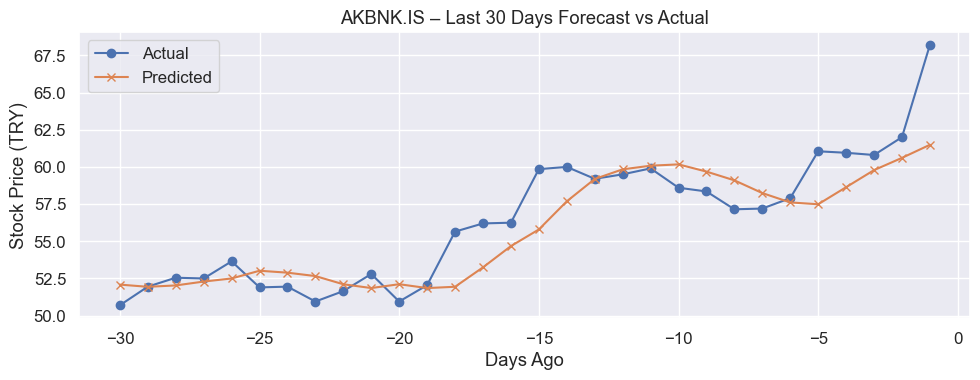

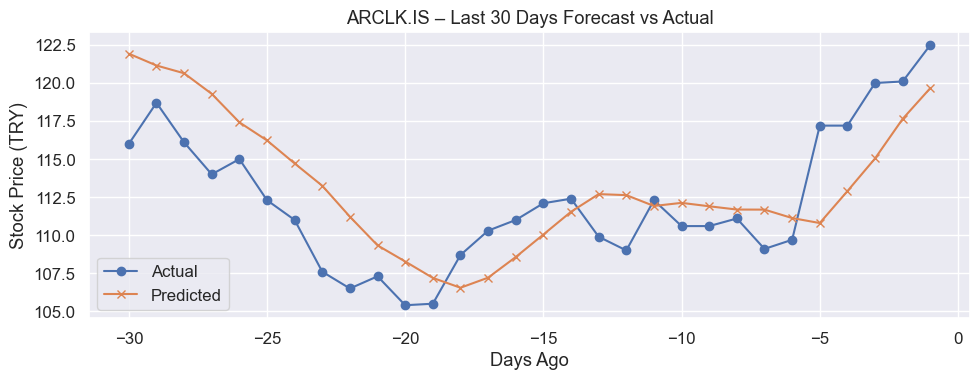

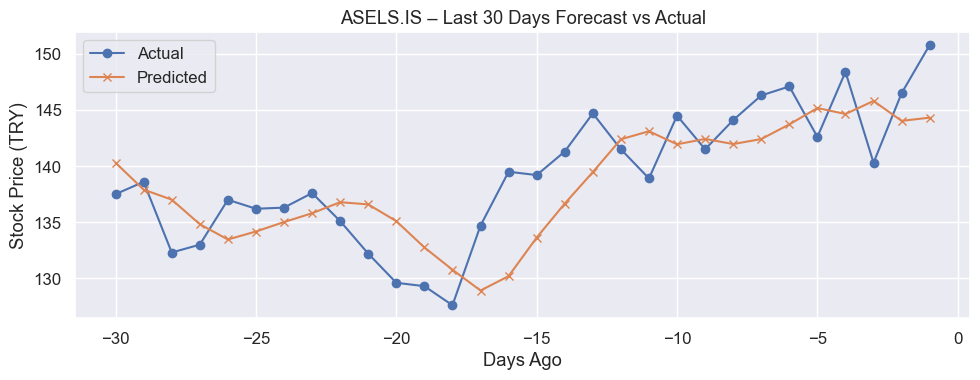

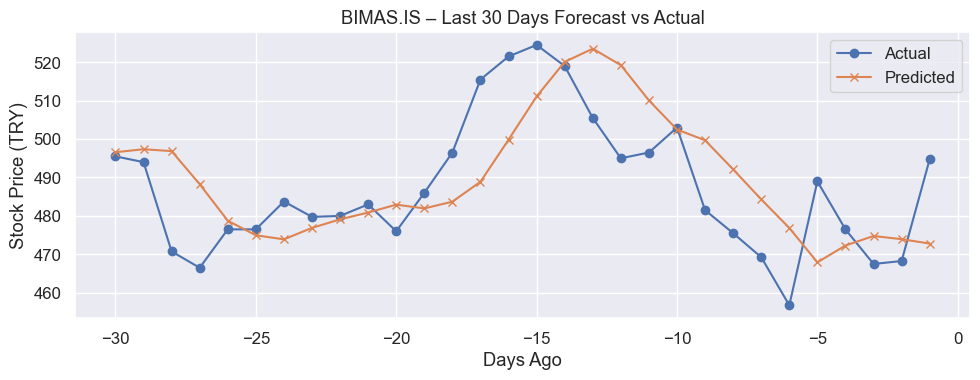

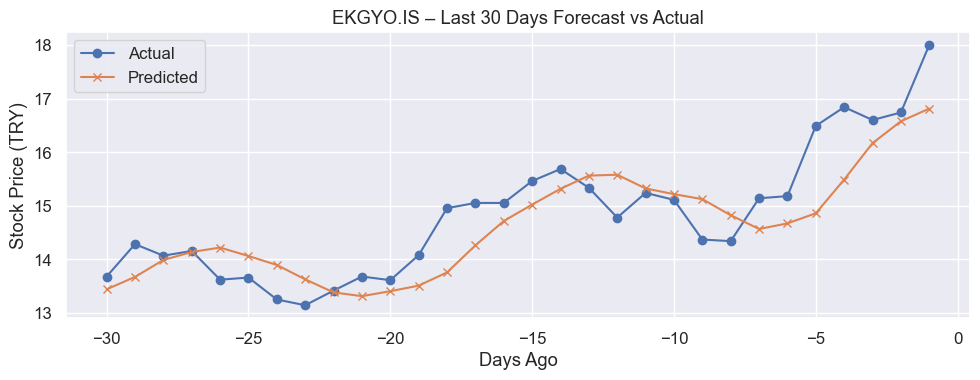

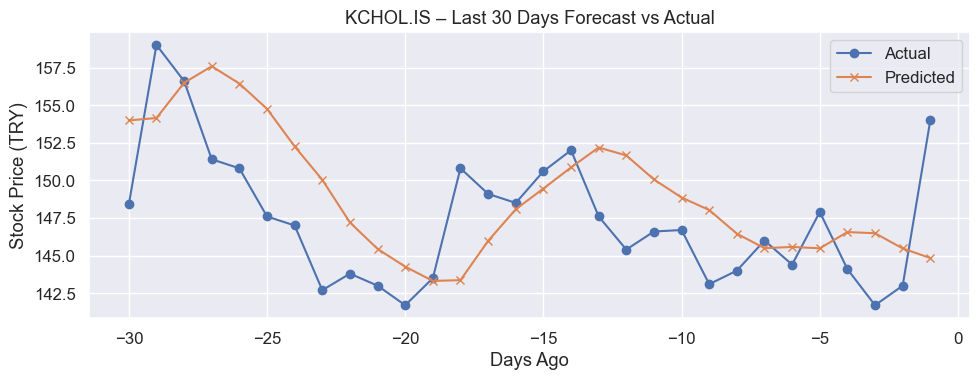

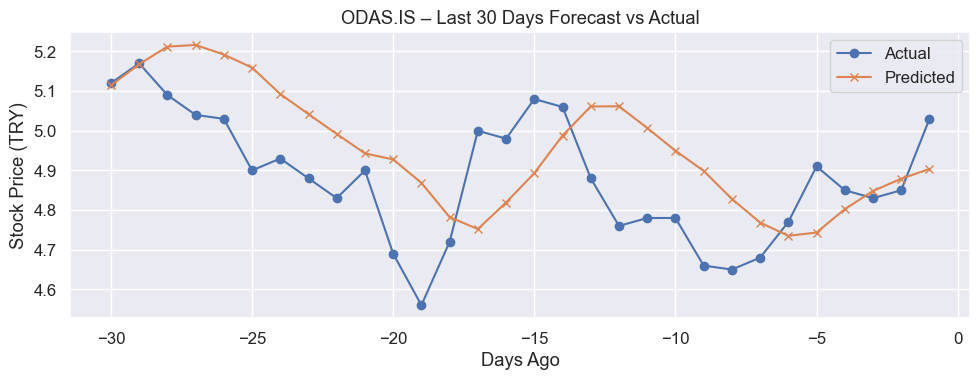

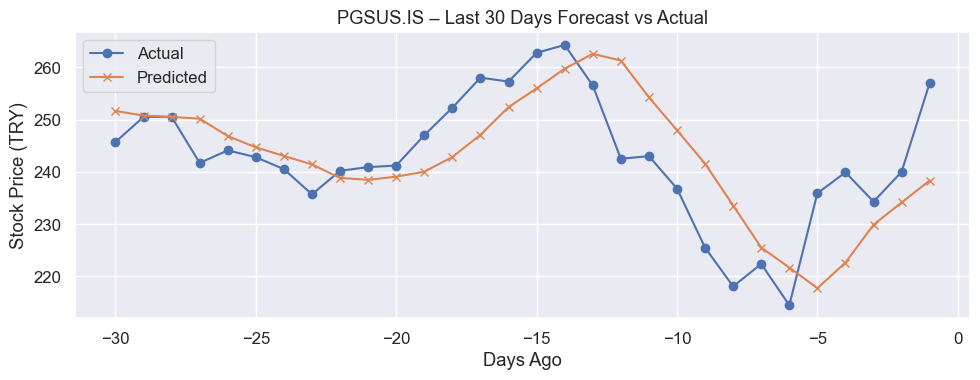

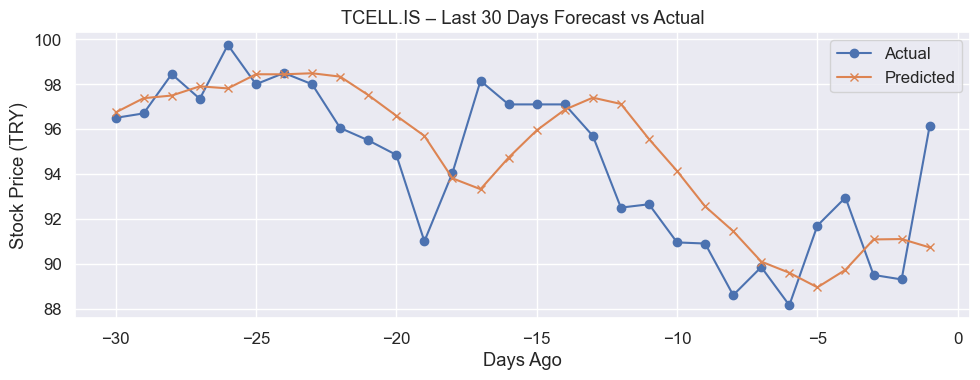

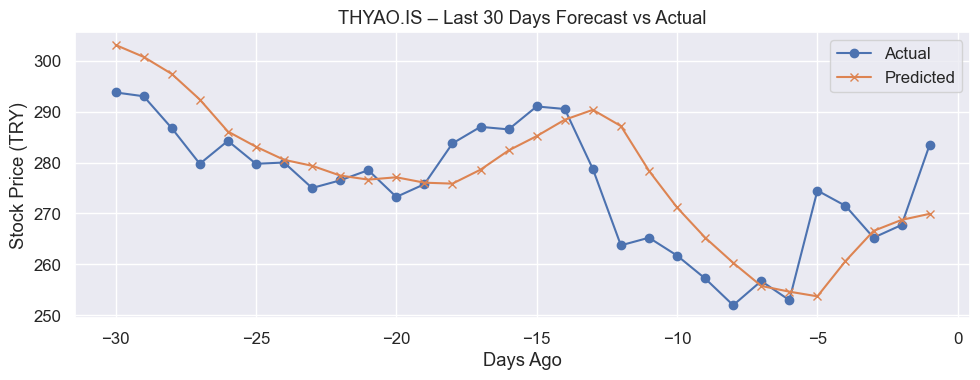

In [26]:
## Visualizing Predicted vs Actual ##

import matplotlib.pyplot as plt

forecast_range = list(range(-30, 0))  # Days relative to end of dataset

for ticker in tickers:
    plt.figure(figsize=(10, 4))
    plt.plot(forecast_range, actual_prices[ticker], label="Actual", marker='o')
    plt.plot(forecast_range, predicted_prices[ticker], label="Predicted", marker='x')
    plt.title(f"{ticker} – Last 30 Days Forecast vs Actual")
    plt.xlabel("Days Ago")
    plt.ylabel("Stock Price (TRY)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



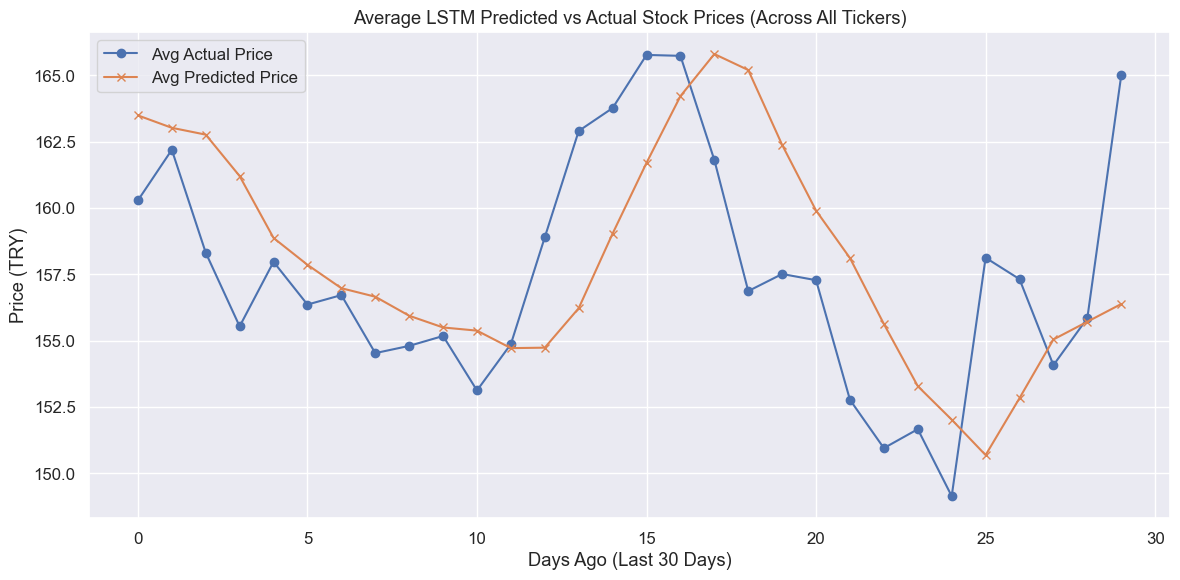

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Average actual/predicted values across all stocks for each of the 30 forecast days
avg_actual = np.mean([actual_prices[t] for t in tickers], axis=0)
avg_pred = np.mean([predicted_prices[t] for t in tickers], axis=0)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(avg_actual, label="Avg Actual Price", marker='o')
plt.plot(avg_pred, label="Avg Predicted Price", marker='x')
plt.title("Average LSTM Predicted vs Actual Stock Prices (Across All Tickers)")
plt.xlabel("Days Ago (Last 30 Days)")
plt.ylabel("Price (TRY)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import numpy as np

# Flattening all predictions and actuals into one big list
flat_actuals = np.concatenate([actual_prices[t] for t in tickers])
flat_preds = np.concatenate([predicted_prices[t] for t in tickers])

# Calculating the overall metrics
rmse = np.sqrt(mean_squared_error(flat_actuals, flat_preds))
mae = mean_absolute_error(flat_actuals, flat_preds)

# Putting into a DataFrame for presentation
performance_summary = pd.DataFrame({
    "RMSE": [rmse],
    "MAE": [mae]
}, index=["LSTM Model"])

from datetime import datetime
print("Evaluation Date:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

print("Model Performance Summary:")
print(performance_summary)

Evaluation Date: 2025-07-02 20:51:42
Model Performance Summary:
                RMSE       MAE
LSTM Model  6.633736  4.057907


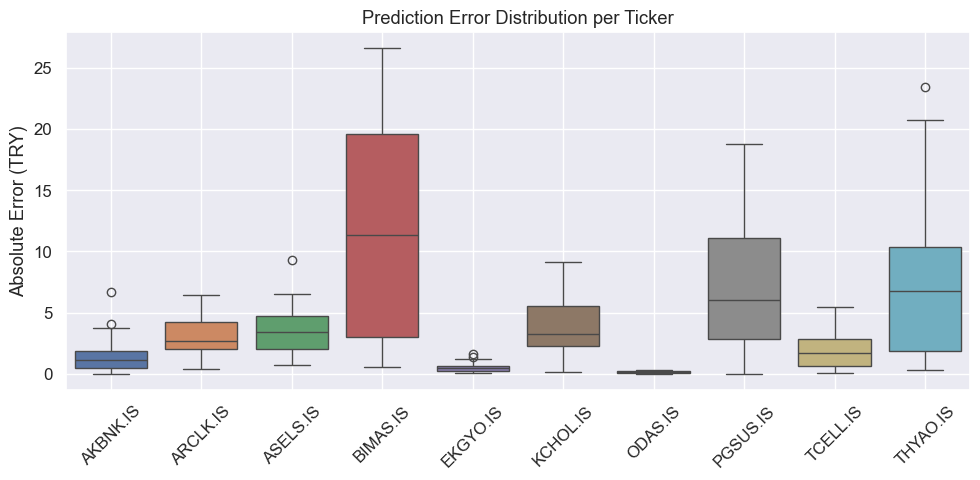

In [31]:
errors = {t: np.abs(np.array(actual_prices[t]) - np.array(predicted_prices[t])) for t in tickers}
error_df = pd.DataFrame(errors)

# Boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(data=error_df)
plt.title("Prediction Error Distribution per Ticker")
plt.ylabel("Absolute Error (TRY)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [35]:
# Save LSTM predictions to CSV for Third Notebook

# Flatten into long DataFrame
pred_df = pd.DataFrame({
    "Ticker": np.repeat(tickers, 30),
    "Day": list(range(-30, 0)) * len(tickers),
    "Actual": np.concatenate([actual_prices[t] for t in tickers]),
    "Predicted": np.concatenate([predicted_prices[t] for t in tickers])
})

pred_df.to_csv("lstm_predictions.csv", index=False)
print("Saved LSTM predictions to 'lstm_predictions.csv'")


Saved LSTM predictions to 'lstm_predictions.csv'
